In [1]:
#Import dependencies
import numpy as np
import cv2
import matplotlib.image as mpimg
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Image common params
i_height, i_width, i_channels = 66,200,3
img_shape = (i_height, i_width, i_channels)

In [3]:
# Dataset common params
data_dir ='./data/data/'
meta_file = data_dir +'driving_log.csv'

In [4]:
#!ls data/data/IMG/ | wc -l 

In [5]:
# Load an image
def load_image(img_path):
    """
    Load RGB image
    """
    return mpimg.imread(os.path.join(data_dir, img_path.strip()))

In [6]:
# Test load_image
meta_df = pd.read_csv(meta_file)
meta_df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [7]:
def visualize_img(img):
    """
    This is an utility to visualize a sample image
    """
    plt.imshow(img)
    plt.show()

Shape of the image:  (160, 320, 3)


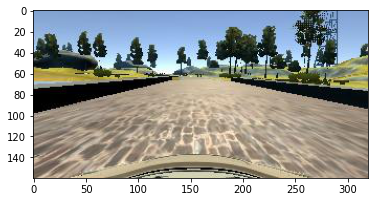

In [8]:
# get a sample image path
image_path_center = meta_df['center'].values[0]
img = load_image(image_path_center)
print("Shape of the image: ", img.shape)
visualize_img(img)

In [9]:
image_path_left = meta_df['left'].values[0]

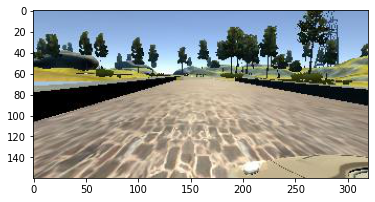

In [10]:
img = load_image(image_path_left)
visualize_img(img)

In [11]:
image_path_right = meta_df['right'].values[0]

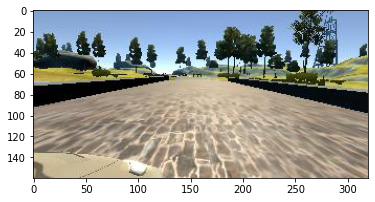

In [12]:
img = load_image(image_path_right)
visualize_img(img)

### Data Preprocessing

In [13]:
# Crop images to extract required road sections and to remove sky from the road
def crop_image(in_img):
    """
    This is used to cropping images 
    """
    
    return in_img[60:-25,:,:]

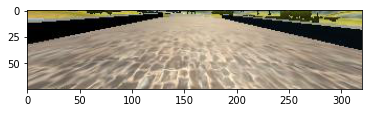

In [14]:
# test crop images
image_path_right = meta_df['right'].values[0]
img = load_image(image_path_right)
croped = crop_image(img)
#visualize 
visualize_img(croped)

In [15]:
# resize the images
def resize_image(in_img):
    """
    This is an utility function to resize images
    """
    return cv2.resize(in_img, (i_width, i_height), cv2.INTER_AREA)

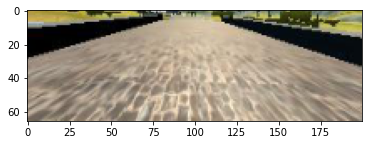

In [16]:
# Test resize images
resized = resize_image(croped)
#visualize 
visualize_img(resized)

In [17]:
# convert RGB to YUV image
def convert_rgb2yuv(in_img):
    """
    This is an utility function to convert RGB images to YUV.
    This technique was intr by NVIDIA for their image pracessing pipeline
    """
    return cv2.cvtColor(in_img, cv2.COLOR_RGB2YUV)

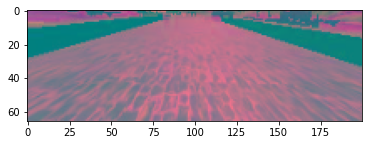

In [18]:
# Test RGB 2 YUV 
yuv = convert_rgb2yuv(resized)
#visualize 
visualize_img(yuv)

In [19]:
# Define image prepocess pipeline
def preprocess(img):
    """
    This is a pipeline for image preprocesing
    """
    img = crop_image(img)
    img = resize_image(img)
    img = convert_rgb2yuv(img)
    return img

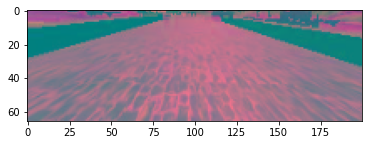

In [20]:
# Test image preprocessing pipeline
image_path_right = meta_df['right'].values[0]
img = load_image(image_path_right)
img = preprocess(img)
visualize_img(img)

### Image Data Augmentation

In [21]:
# Flip images
def random_flip(img, streeing_angle):
    """
    
    """
    if np.random.rand() <0.5:
        img = cv2.flip(img, 1)
        streeing_angle = - streeing_angle
    
    return img, streeing_angle    

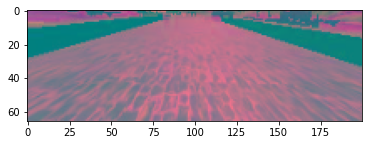

In [22]:
# Test for flipping
image_path_right = meta_df['right'].values[0]
img = load_image(image_path_right)
img = preprocess(img)
img , string_angle = random_flip(img, 0.1)
visualize_img(img)
              

In [23]:
# Translate images
def random_translate(img, streering_angle, range_x, range_y):
    """
    
    """
    
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    streering_angle += trans_x * 0.002
    trans_m = np.float32([[1,0,trans_x], [0,1, trans_y]])
    h,w = img.shape[:2]
    img = cv2.warpAffine(img, trans_m, (w,h))
    return img, streering_angle

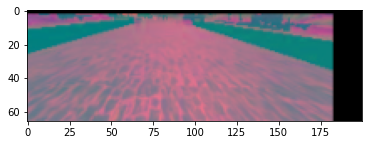

In [24]:
# Test for translate
image_path_right = meta_df['right'].values[0]
img = load_image(image_path_right)
img = preprocess(img)
img , string_angle = random_translate(img, 0.1, 100, 10)

visualize_img(img)
              

In [25]:
# Add random shadow
def random_shadow(img):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = i_width * np.random.rand(), 0
    x2, y2 = i_width * np.random.rand(), i_height
    xm, ym = np.mgrid[0:i_height, 0:i_width]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(img[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

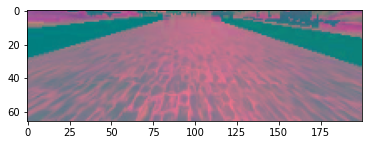

In [26]:
# Test for shaow adgusments
image_path_right = meta_df['right'].values[0]
img = load_image(image_path_right)
img = preprocess(img)
img = random_shadow(img)

visualize_img(img)


In [27]:
# Adgust brightness randomly
def random_brightness(img):
    """
    """
    
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

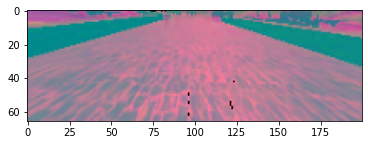

In [28]:
# Test for shaow adgusments
image_path_right = meta_df['right'].values[0]
img = load_image(image_path_right)
img = preprocess(img)
img = random_brightness(img)

visualize_img(img)


In [29]:
# Image data augmentation
def augment(img, streering_angle, range_x =100, range_y=10):
    """
    Augmenting images
    """
    img, streering_angle = random_flip(img, streering_angle)
    img, streering_angle = random_translate(img, streering_angle, range_x, range_y)
    img = crop_image(img)
    img = resize_image(img)
    img = random_shadow(img)
    img = random_brightness(img)
    img = convert_rgb2yuv(img)
    return img, streering_angle
    

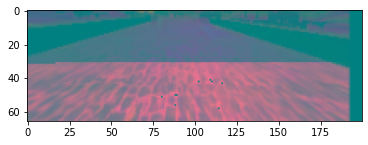

In [30]:
# test image data augmentation
image_path_right = meta_df['right'].values[0]
img = load_image(image_path_right)
img, string_angle = augment(img, 0.2)
visualize_img(img)

In [31]:
# select random images
def select_random_image(center , left, right, streering_angle):
    """
    """
    choise = np.random.randint(3)
    if choise == 0:
        return load_image(left), streering_angle + 0.2
    elif choise == 1:
        return load_image(right), streering_angle - 0.2
    
    return load_image(center) , streering_angle        

In [40]:
# Generate augmentation batch
def generate_batch(image_paths, streering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, i_height, i_width, i_channels])
    streerings = np.empty(batch_size)

    while True:
        i = 0
        for idx in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[idx]
            steering_angle = streering_angles[idx]

            if is_training and np.random.rand() < 0.6:
                img, steering_angle = select_random_image(center, left, right, steering_angle)
                # Augmenting
                img, steering_angle = augment(img, steering_angle)
            else:
                img = load_image(center)
                img = preprocess(img)

            images[i] = img
            streerings[i] = steering_angle
            i += 1

            if i == batch_size:
                break

        yield images, streerings

In [41]:
# test batch generates
images_paths = meta_df[['center', 'left', 'right']].values
streering_angles = meta_df['steering'].values
batch = generate_batch(images_paths,streering_angles, 10, True)
type(batch)

generator